# Evaluación de SPASS (test dataset)

In [8]:
%load_ext autoreload 
%autoreload 2

import yaml
import json
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from fusanet_utils.datasets.fusa import FUSA_dataset
from fusanet_utils.transforms import Collate_and_transform
from fusanet_utils.datasets.simulated import SimulatedPoliphonic

dataset = SimulatedPoliphonic('../..', external=True, mini=False)

scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
is_scenario = lambda filename: [key for key, scene in scenarios.items() if scene in filename][0]

models_metadata = {0: {'name': 'Adavanne et al. 2017', 
                       'path': Path('../../experiments/Poliphonic-ADAVANNE-sed/')},
                   1: {'name': 'Kong et al. 2019', 
                       'path': Path('../../experiments/Poliphonic-PANN-sed-no-pretrained/')},
                   2: {'name': 'Chen et al. 2021 (loss)', 
                       'path': Path('../../experiments/Poliphonic-HTS-valid-loss/')},
                   3: {'name': 'Chen et al. 2021', 
                       'path': Path('../../experiments/Poliphonic-HTS/')}
                  }

    
preds_soft, labels, distances, places = {}, {}, {}, {}
for model_idx in [1, 2]:
    experiment_path = models_metadata[model_idx]['path']
    #categories = json.load(open(str(experiment_path / 'index_to_name.json')))
    model = torch.load(str(experiment_path / 'model.pt'))
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters number: {pytorch_total_params}')
    print(f'Trainable parameters number: {pytorch_trainable_params}')
    model.eval()
    params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))
    fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), params=params)
    fusa_loader = DataLoader(fusa_dataset, batch_size=10, shuffle=False, pin_memory=True, num_workers=2,
                             collate_fn=Collate_and_transform(params["features"]))
    preds_model, labels_model, distances_model = [], [], []
    with torch.no_grad():
        for sample in tqdm(fusa_loader):
            preds_model.append(model(sample).numpy())
            labels_model.append(sample['label'].numpy())
            distances_model.append(sample['distance'].numpy())
    preds_soft[model_idx] = np.concatenate(preds_model)
    labels[model_idx] = np.concatenate(labels_model)
    distances[model_idx] = np.concatenate(distances_model)
    places[model_idx] = np.array([is_scenario(sample[0].stem) for sample in dataset])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total parameters number: 79480452
Trainable parameters number: 78396996


  0%|          | 0/10 [00:00<?, ?it/s]

Total parameters number: 28771163
Trainable parameters number: 27687707


  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
preds = {model: preds_soft[model] > 0.5 for model in preds_soft.keys()}

## Por clase para todos los ambientes

In [24]:
#https://stackoverflow.com/questions/65070070/highlight-the-best-value-of-each-row-in-python-pandas-to-latex

import pandas as pd

df = []
for idx in preds.keys():
    insertions = np.mean((preds[idx] == 1) & (labels[idx] == 0), axis=(0, 1))
    deletions = np.mean((preds[idx] == 0) & (labels[idx] == 1), axis=(0, 1))
    error_rate = insertions + deletions
    df.append(pd.Series(100*error_rate, index=list(dataset.categories), name=models_metadata[idx]['name']))
    
print(pd.concat(df, axis=1).to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
{} &  Kong et al. 2019 &  Chen et al. 2021 (loss) \\
\midrule
Vwater            &              4.79 &                     3.30 \\
air\_conditioner   &              5.68 &                     5.58 \\
airborne          &             11.17 &                    10.84 \\
alarm             &              2.81 &                     2.88 \\
bells             &              2.77 &                     2.88 \\
bird              &             10.42 &                     9.70 \\
braking           &              0.68 &                     0.69 \\
bus\_idling        &              8.28 &                     8.03 \\
bus\_moving        &              7.32 &                     6.67 \\
car\_idling        &             18.07 &                    16.26 \\
car\_moving        &             10.18 &                     4.96 \\
crowd             &             31.72 &                    30.75 \\
cutting           &              8.01 &                     7.62 \\
dog               &

/tmp/ipykernel_27905/946657874.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(df, axis=1).to_latex(float_format="%.2f"))


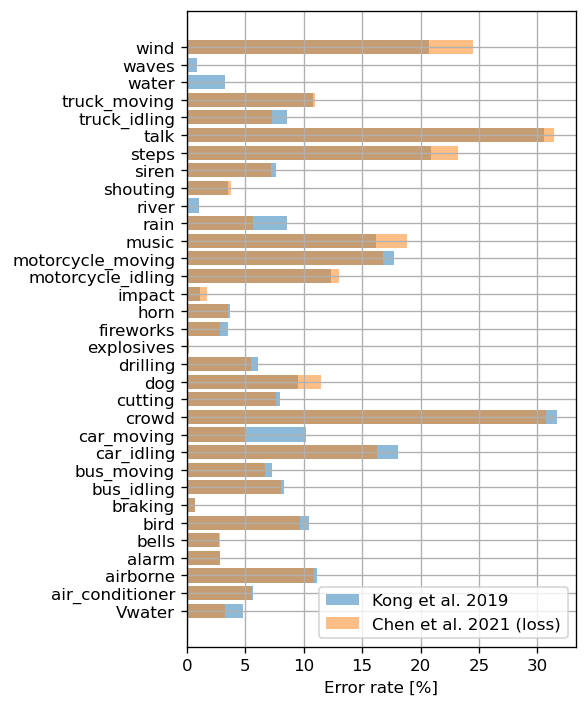

In [10]:
fig, ax = plt.subplots(figsize=(5, 6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    insertions = np.mean((preds[idx] == 1) & (labels[idx] == 0), axis=(0, 1))
    deletions = np.mean((preds[idx] == 0) & (labels[idx] == 1), axis=(0, 1))
    error_rate = insertions + deletions
    ax.barh(y=list(dataset.categories), width=100*error_rate, alpha=0.5, label=models_metadata[idx]['name'])

ax.legend()
ax.grid()
ax.set_xlabel('Error rate [%]');

## Por ambiente separado por clase:

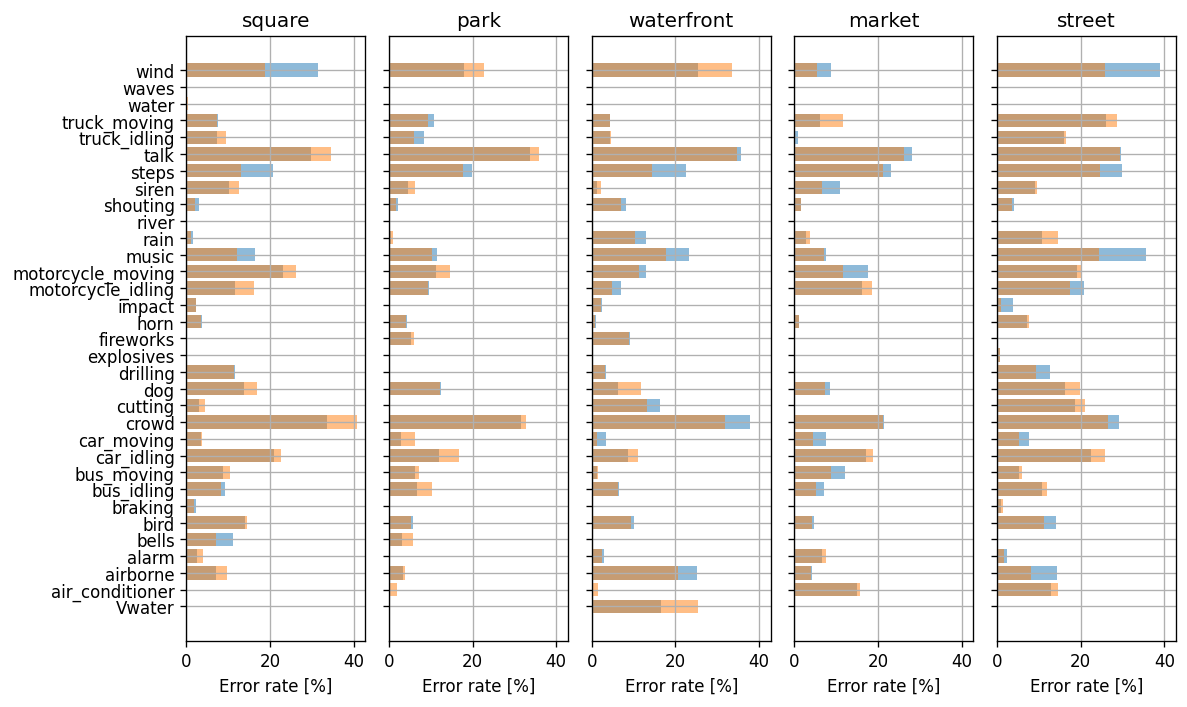

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(10,  6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    insertions, deletions = [], []
    for place in scenarios.keys():
        mask = places[idx] == place
        insertions.append((preds[idx][mask] == 1) & (labels[idx][mask] == 0))
        deletions.append((preds[idx][mask] == 0) & (labels[idx][mask] == 1))        
    insertions = np.mean(np.stack(insertions), axis=(1, 2))
    deletions = np.mean(np.stack(deletions), axis=(1, 2))
    
    for ax_, ins, dels, scene in zip(ax, insertions, deletions, scenarios.values()):
        #print(ins)
        error_rate = (ins + dels)*100
        ax_.barh(y=list(dataset.categories), width=error_rate, 
                 label=models_metadata[idx]['name'], alpha=0.5)
        ax_.set_title(scene)
        ax_.grid('on')
        #ax_.legend()
        ax_.set_xlabel('Error rate [%]')

## Por ambiente:

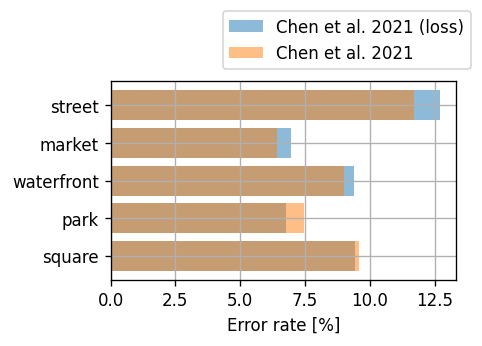

In [6]:
fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    insertions, deletions = [], []
    for place in scenarios.keys():
        mask = places[idx] == place
        insertions.append((preds[idx][mask] == 1) & (labels[idx][mask] == 0))
        deletions.append((preds[idx][mask] == 0) & (labels[idx][mask] == 1))        
    insertions = np.mean(np.stack(insertions), axis=(1, 2, 3))
    deletions = np.mean(np.stack(deletions), axis=(1, 2, 3))
    error_rate = 100*(insertions+deletions)
    ax.barh(y=list(scenarios.values()), width=error_rate, 
            label=models_metadata[idx]['name'], alpha=0.5)

ax.legend(bbox_to_anchor=(0.3, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('Error rate [%]');

## Por macro clase:

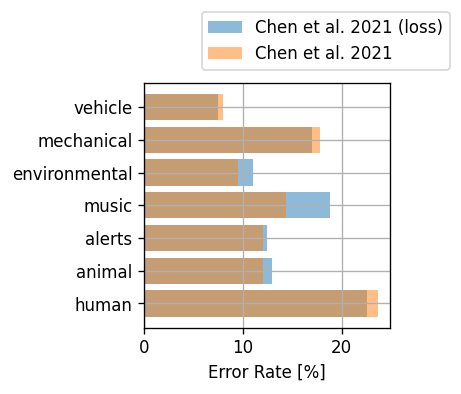

In [7]:
categories = {}
for k, category in enumerate(dataset.categories):
    categories[k] = category
inv_categories = {}
for key, values in categories.items():
    inv_categories[values] = int(key)
    
macro_classes = ['human', 'animal', 'alerts', 'music', 'environmental', 'mechanical', 'vehicle']
fusa_taxonomy = {0: ['crowd', 'shouting', 'talk', 'steps'],
                 1: ['bird', 'dog'], 
                 2: ['siren', 'bells', 'alarm', 'horn', 'braking'],
                 3: ['music'],
                 4: ['rain', 'wind', 'water', 'river', 'waves'],
                 5: ['cutting', 'drilling', 'fireworks', 
                     'impact', 'explosives', 'air_conditioner'],
                 6: ['car_idling', 'car_moving', 'bus_idling', 'bus_moving', 'airborne',
                     'motorcycle_idling', 'motorcycle_moving', 'truck_idling', 'truck_moving', 'Vwater']
                }
fusa_taxonomy_int = {}
for key, values in fusa_taxonomy.items():
    transformed_values = []
    for value in values:
        transformed_values.append(inv_categories[value])
    fusa_taxonomy_int[key] = transformed_values
        
inv_taxonomy = {}
for key, values in fusa_taxonomy_int.items():
    for value in values:
        inv_taxonomy[value] = key
        

fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)


for idx in preds.keys():    
    pred_macro = np.stack([np.amax(preds[idx][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(macro_classes))])
    label_macro = np.stack([np.amax(labels[idx][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(macro_classes))])

    insertions = np.mean((pred_macro == 1) & (label_macro==0), axis=(1, 2))
    deletions = np.mean((pred_macro == 0) & (label_macro==1), axis=(1, 2))

    error_rate = 100*(insertions + deletions)
    ax.barh(y=macro_classes, width=error_rate, label=models_metadata[idx]['name'], alpha=0.5)
ax.legend(bbox_to_anchor=(0.2, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('Error Rate [%]');

## Recall según distancia

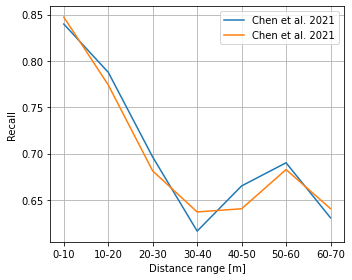

In [8]:
fig, ax = plt.subplots(figsize=(5,4),facecolor='w', tight_layout=True)
thresholds = [0, 10, 20, 30, 40, 50, 60, 70]
        
for model_idx in preds.keys():

    deletion_mask = (preds[model_idx]==0) & (labels[model_idx]==1)
    correct_mask = (preds[model_idx]==1) & (labels[model_idx] ==1)
    """
    fig, ax = plt.subplots(figsize=(6, 4), facecolor='w')

    ax.hist(distances[model_idx][deletion_mask], bins=30, alpha=0.5, density=True, 
            label='Deletions (FN)', range=(0, 100))
    ax.hist(distances[model_idx][correct_mask], bins=30, alpha=0.5, density=True, 
            label='Detections (TP)', range=(0, 100))
    ax.legend()
    ax.set_xlabel('Distance to sensor [m]')
    """
    recall = []
    for k in range(len(thresholds)-1):
        dist_mask = (distances[model_idx] > thresholds[k]) & (distances[model_idx] <= thresholds[k+1])
        FN = sum(deletion_mask[dist_mask])
        TP = sum(correct_mask[dist_mask])
        recall.append(TP/(TP+FN))

    ax.plot(thresholds[:-1], recall, label=models_metadata[idx]['name'])

ax.legend()
ax.grid()
ax.set_ylabel('Recall')
ax.set_xlabel('Distance range [m]')
ax.set_xticks(thresholds[:-1])
ax.set_xticklabels([f"{th1}-{th2}" for th1, th2 in zip(thresholds[:-1], thresholds[1:])]);